## Pneumonia Detection from Chest X-ray Images

<p align="center">
   <img width="621" alt="Screenshot 2021-02-07 at 17 30 12" src="https://user-images.githubusercontent.com/76659596/107152793-30234600-696a-11eb-8827-56cb0c3a7578.png">
</p>

In this notebook, a `Convolutional Neural Network (CNN)` has been developed and trained to select the presence of `pneumonia` disease by analyzing chest X-ray images.

This is a `binary classification` problem where the outcome is either a person has `pneumonia` disease or not (`normal` condition).

This model is built from scratch, i.e. not relying on transfer learning approaches (pre-trained models).

### Import Libraries

Conv2D卷积神经网络 
 https://blog.csdn.net/Checkmate9949/article/details/119609758?spm=1001.2101.3001.6650.1&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-1-119609758-blog-121042872.pc_relevant_antiscanv3&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-1-119609758-blog-121042872.pc_relevant_antiscanv3

Conv2D()卷积层
filters: 过滤器数量
kernel_size: 指定（方形）卷积窗口的高和宽的数字
strides: 卷积步长, 默认为 1
padding: 卷积如何处理边缘。选项包括 ‘valid’ 和 ‘same’。默认为 ‘valid’
activation: 激活函数，通常设为 relu。如果未指定任何值，则不应用任何激活函数。强烈建议你向网络中的每个卷积层添加一个 ReLU 激活函数。
input_shape: 指定输入层的高度，宽度和深度的元组。当卷积层作为模型第一层时，必须提供此参数，否则不需要。

最大池化层
MaxPooling2D(pool_size, strides, padding)

pool_size: 指定池化窗口高度和宽度的数字
strides: 垂直和水平 stride。如果不指定任何值，则 strides 默认为 pool_size
padding: 选项包括 valid 和 same。如果不指定任何值，则 padding 设为 valid

In [8]:
import os

import matplotlib.pyplot as plt
%matplotlib inline

from texttable import Texttable

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D, \
    Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Configurations

In [9]:
MODEL_LOC = '../model/pneumonia_detection_cnn_model.h5'
DATA_DIR = '..\data'    #数据集路径
TRAINING_DATA_DIR = DATA_DIR + '/train/'
TEST_DATA_DIR = DATA_DIR + '/test/'
VAL_DATA_DIR = DATA_DIR + '/val/'
DETECTION_CLASSES = ('NORMAL', 'PNEUMONIA')
BATCH_SIZE = 32   #batch数据的大小
EPOCHS = 100      #轮数

### Exploratory Data Analysis (EDA)

In [10]:
#计算每个数据集和相关的两个类别（正常和肺炎）的图像数量
# counting the number of images for every dataset and the associated two classes (Normal and Pneumonia)
def count_images(directory_name, detection_class):
    return len(os.listdir(directory_name + detection_class))

t = Texttable() 

t.add_rows([['Dataset Type', 'Normal', 'Pneumonia'], 
            ['Training', count_images(TRAINING_DATA_DIR, 'NORMAL'), count_images(TRAINING_DATA_DIR, 'PNEUMONIA')], 
            ['Test', count_images(TEST_DATA_DIR, 'NORMAL'), count_images(TEST_DATA_DIR, 'PNEUMONIA')],
            ['Validation', count_images(VAL_DATA_DIR, 'NORMAL'), count_images(VAL_DATA_DIR, 'PNEUMONIA')]
           ])
print(t.draw())

+--------------+--------+-----------+
| Dataset Type | Normal | Pneumonia |
+==============+========+===========+
| Training     | 1341   | 4006      |
+--------------+--------+-----------+
| Test         | 366    | 390       |
+--------------+--------+-----------+
| Validation   | 47     | 48        |
+--------------+--------+-----------+


As can be seen from the above data exploration, the data is highly imbalanced. That is, the number of images for `pneumonia` cases are much higher than the `normal` cases. However, this is expected in the medical data, as a person is advised to have the X-ray done if some symptoms are noticed and hence more likely to have the disease.

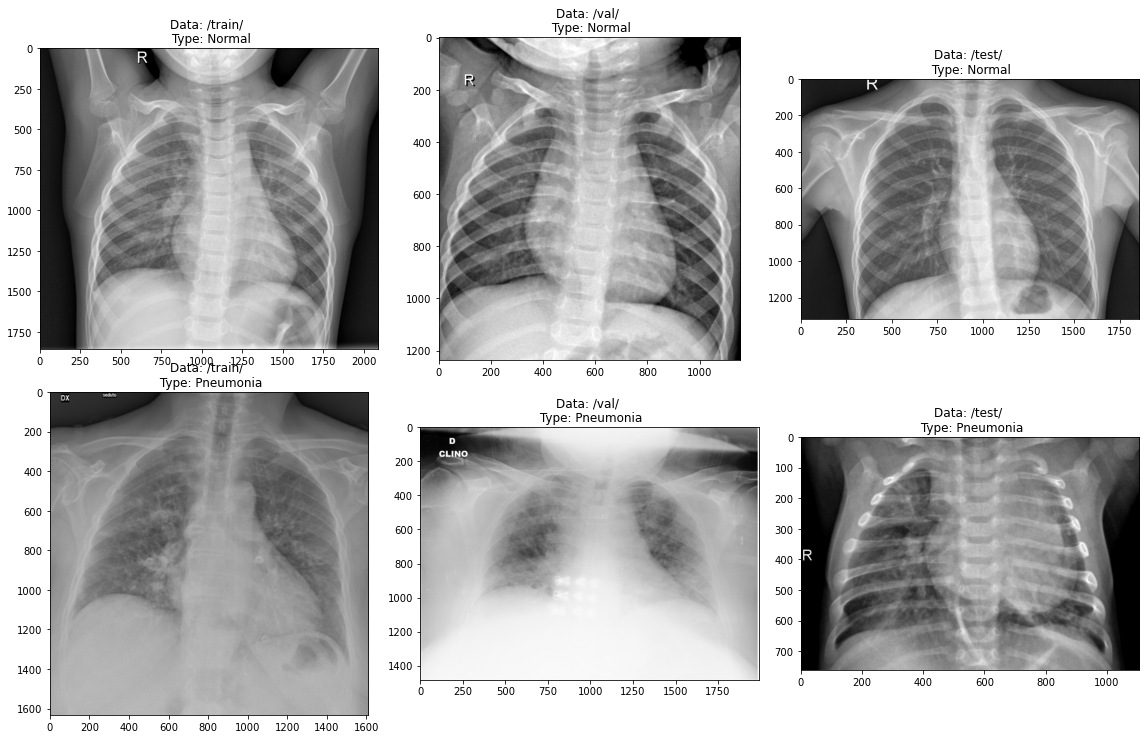

In [11]:
# Looking at one image per class in each dataset type
fig, ax = plt.subplots(2, 3, figsize = (16, 10))  #创建2行3列的子图，图片大小为16X10
ax = ax.ravel()
plt.tight_layout()

for i, subdir in enumerate(['/train/', '/val/', '/test/']):
    image_path = DATA_DIR + subdir  #data/train   训练集地址
    ax[i].imshow(plt.imread(image_path + '/NORMAL/' + os.listdir(image_path + '/NORMAL')[0]), cmap='gray')#图片
    ax[i].set_title('Data: {} \n Type: Normal'.format(subdir), fontsize = 12)#标题
    ax[i+3].imshow(plt.imread(image_path + '/PNEUMONIA/' + os.listdir(image_path + '/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Data: {} \n Type: Pneumonia'.format(subdir), fontsize = 12)

### Prepare Data

In [28]:
# data generator on training dataset, data augmentation applied
#训练集数据生成，数据增强应用

# 图片增强
# ImageDataGenerator（）
#     rescale=所有数据集将乘以该数值,
#     rotation_range=随即旋转角度数范围,
#     width_shift_range=随即宽度偏移量,
#     height_shift_range=随即高度偏移量,
#     horizontal_flip=是否随机水平翻转,
#     zoom_range=随机缩放的范围 -> [1-n,1+n]）zoom_range: 浮点数 或 [lower, upper]。随机缩放范围。如果是浮点数，[lower, upper] = [1-zoom_range, 1+zoom_range]。zoom_range参数可以让图片在长或宽的方向进行放大，可以理解为某方向的resize，因此这个参数可以是一个数或者是一个list。当给出一个数时，图片同时在长宽两个方向进行同等程度的放缩操作；当给出一个list时，则代表[width_zoom_range, height_zoom_range]，即分别对长宽进行不同程度的放缩。
#     而参数大于0小于1时，执行的是放大操作，当参数大于1时，执行的是缩小操作。
#     该函数可以增强图片数据，需要fit函数来对指定的数据进行增强，这里要求是四维数据（图片张数，图片长度，图片宽度，灰度），先reshape为四维数据然后调用fit函数e
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0,
                                   shear_range=0.2,   #浮点数。剪切强度（以弧度逆时针方向剪切角度）
                                   vertical_flip=True,
                                   rotation_range=10,  #整数。随机旋转的度数范围
                                   zoom_range=0.3)  #图片放大操作

# preprocessing the training dataset  对训练数据集进行预处理
training_dataset = train_datagen.flow_from_directory(TRAINING_DATA_DIR,
                                                     classes=DETECTION_CLASSES,
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE,  #32
                                                     target_size=(224, 224))  #图像将被resize成224X224尺寸

#flow_from_directory(directory): 以文件夹路径为参数,生成经过数据提升/归一化后的数据,在一个无限循环中无限产生batch数据


# data generator on test dataset, data augmentation not applied
# 测试数据集上的数据生成器，未应用数据增强
# used as validation dataset as the val dir contains only 16 images
# 用作验证数据集，因为 val 目录仅包含 16 个图像
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# preprocessing the test dataset (used as validation)  对测试集进行预处理
test_dataset = test_datagen.flow_from_directory(TEST_DATA_DIR,
                                                classes=DETECTION_CLASSES,  #为子文件夹的列表，每一个子文件夹都会被认为是一个新的类
                                                shuffle=False,  #是否打乱数据,默认为True
                                                batch_size=BATCH_SIZE,   # batch数据的大小,默认32，每次丢32个数据进行训练
                                                target_size=(224, 224))  #: 整数tuple,默认为(256, 256). 图像将被resize成该尺寸

# data generator on validation dataset, data augmentation not applied
# 验证数据集上的数据生成器，未应用数据增强
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# preprocessing the validation dataset
#对验证数据集进行预处理
val_dataset = test_datagen.flow_from_directory(VAL_DATA_DIR,
                                               classes=DETECTION_CLASSES,
                                               shuffle=False,
                                               batch_size=BATCH_SIZE,
                                               target_size=(224, 224)) #图像将被resize成224X224尺寸

SyntaxError: invalid character in identifier (<ipython-input-28-4169c1cf512d>, line 24)

In [13]:
# printing the assigned indices for sanity check
# 打印分配的索引以进行完整性检查
print(f'class indices:  {training_dataset.class_indices}')

class indices:  {'NORMAL': 0, 'PNEUMONIA': 1}


### Build `CNN` Model

The following model consists of five `convolution` blocks where after each block, a pooling layer (`max pooling`) is added. The `flattening` layer after the last convolution block prepares the input to be fed into the fully connected layers. In each fully connected layer, `dense` method is used to add a hidden layer where `units` represent the number of nodes/neurons in that layer. The last fully connected layer has two nodes representing the two classes - `pneumonia` and `normal` where the `softmax` activation function (as the two cases are mutually exclusive case) is used. One can also use in this case the `sigmoid` activation function with one unit in the output layer with `binary cross-entropy` loss. 

以下模型由五个“卷积”块组成，在每个块之后，添加一个池化层（“最大池化”）。 最后一个卷积块之后的“扁平化”层准备将输入馈送到全连接层。 在每个全连接层中，`dense` 方法用于添加一个隐藏层，其中`units` 表示该层中节点/神经元的数量。 最后一个全连接层有两个节点代表两个类——“肺炎”和“正常”，其中使用了“softmax”激活函数（因为这两种情况是互斥的）。 在这种情况下，也可以使用“sigmoid”激活函数，在输出层中有一个单元，具有“二元交叉熵”损失。

In [14]:
cnn_model = Sequential()  #网络构造,初始化模型

# First Block of CNN
cnn_model.add(Conv2D(16, (3, 3 ), padding='same', input_shape=(224, 224, 3), activation='relu'))
#输出将具有16个特征图（卷积核个数）,内核大小为3X3，输入形状是224x224x3（rgb三通道）    输出224*224*16
# padding = same。保留体积的空间尺寸，以便输出体积大小与输入体积大小匹配,这意味着需要相同尺寸的输出作为输入。 Keras Conv2D 填充参数接受“valid”（无填充）或“same”（填充 + 保留空间维度)
##激活指定激活函数。
#添加另一个卷积层 
cnn_model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
#输出224*224*16
#添加一个最大池化层
cnn_model.add(MaxPooling2D((2, 2)))  #Max Pooling：表示矩形邻域内的最大输出。2*2池化核心
#最大拼接用于减少输出体积的空间尺寸
#输出112*112*16
#  Second Block of CNN


#BatchNormalization()
#求出每一行的均值与标准差后，这一行的每一个值都进行“减均值再除以标准差”操作
# 训练深度网络的时候经常发生训练困难的问题，因为，每一次参数迭代更新后，上一层网络的输出数据经过这一层网络计算后，数据的分布会发生变化，
# 为下一层网络的学习带来困难（神经网络本来就是要学习数据的分布，要是分布一直在变，学习就很难了），此现象称之为Internal Covariate Shift.
#最重要）可以加快训练速率，即可以增大学习率，加快模型的收敛速度,不过分依赖网络初始值,一定程度上抑制了过拟合情况，降低了Dropout的必要性
#BN层指的是对输入神经网络的一批次feature map数据的每一个通道进行归一化操作，使得输入每一维度满足均值为0方差为1的数据分布。
#这里需要注意的是，如果每一层都满足均值为0方差为1的标准正态分布，那么网络很难学习到新的信息，
# 所以在最后需要添加缩放以及平移信息，以达到每一次数据经过归一化后还保留的有学习来的特征。

cnn_model.add(SeparableConv2D(32, (3, 3), padding='same', activation='relu')) #输入为112*112*16的矩阵与3*3*32的卷积块运算，输出为112*112*32
cnn_model.add(SeparableConv2D(32, (3, 3), padding='same', activation='relu')) #输出为112*112*32
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))#降维，缩放  输出为56*56*32

#  Third Block of CNN
cnn_model.add(SeparableConv2D(64, (3, 3), padding='same', activation='relu'))#输出56*56*64
cnn_model.add(SeparableConv2D(64, (3, 3), padding='same', activation='relu'))#输出56*56*64
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))#输出28*28*64


#dropout是一种针对神经网络模型的正则化方法。是在训练过程中，随机的忽略部分神经元。
# 它强迫一个神经元单元和随机挑选出来的其他神经单元共同工作，达到较好的效果，减弱了神经节点间的联合适应性，
# 增强了泛化能力。经过验证，隐含节点dropout率等于0.5的时候效果最好。此时dropout随机生成的网络结构最多，
# dropout也可以用在输入层，作为一种添加噪音的方法。
#在keras的每个权重更新周期中，按照给定概率（如20%），随机选择要丢弃的节点，以实现dropout。
# dropout只能在模型的训练过程中使用，在评估模型时不能使用。
#  Fourth Block of CNN
cnn_model.add(SeparableConv2D(128, (3, 3), padding='same', activation='relu'))#输出28*28*128
cnn_model.add(SeparableConv2D(128, (3, 3), padding='same', activation='relu'))#输出28*28*128
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))#输出14*14*128
cnn_model.add(Dropout(rate=0.2))

#  Fifth Block of CNN
cnn_model.add(SeparableConv2D(256, (3, 3), padding='same', activation='relu'))#输出14*14*256
cnn_model.add(SeparableConv2D(256, (3, 3), padding='same', activation='relu'))#输出14*14*256
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))#输出7*7*256
cnn_model.add(Dropout(rate=0.2))

#  Flatten and Fully Connected Layer
cnn_model.add(Flatten())#扁平化处理，转换为12544维
cnn_model.add(Dense(units=512, activation='relu'))#隐藏层，输出512维
cnn_model.add(Dropout(rate=0.7))
cnn_model.add(Dense(units=128, activation='relu'))#输出128维
cnn_model.add(Dropout(rate=0.5))
cnn_model.add(Dense(units=64, activation='relu'))#输出64维
cnn_model.add(Dropout(rate=0.3))

#  Softmax Classifier
cnn_model.add(Dense(units=2, activation='softmax'))#两个输出

#  Display model  
# 输出模型结构
cnn_model.summary()

# compile model
#model.compile()方法用于在配置训练方法时，告知训练时用的优化器、损失函数和准确率评测标准。 
# model.compile(optimizer = 优化器，loss = 损失函数，metrics = ["准确率”])
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 112, 112, 32)      688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 112, 112, 32)      1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0

### Train `CNN` Model


EarlyStopping使用该函数的目的是为了防止过拟合，因为在我们训练模型的过程中，很有可能出现过拟合的情况。
这个时候训练集表现很好，但是验证集表现就会下降。这时候我们需要提前结束训练，得到“最佳”（只能判断是在全局范围内最佳）的结果。
monitor: 监控的变量，例如val_acc,val_loss。如果要保存最高的精度,则应将检查点设置为monitor =’val_acc’,它将自动以最高的精度保存.最低的损耗不一定与最高的精度相对应
min_delta: monitor的最小变化，如果绝对值小于min_delta，则可以看作对于结果没有improvement，默认为0。
patience: 没有改善的epoch数。比如例子中为10次内都没有改变。
verbose：日志显示

verbose = 0 为不在标准输出流输出日志信息
verbose = 1 为输出进度条记录
verbose = 2 为每个epoch输出一行记录
mode: auto, min, max三者之一. 在最小模式下，当监控量停止下降时，培训将停止; 在最大模式下，当监控量停止增加时，它将停止; 在自动模式下，从监控数量的名称自动推断方向。
restore_best_weights: 若为True，将会取整个训练过程中最佳监控值的epoch训练结果作为最终模型权值，否则将以最后一次epoch的结果作为最终模型权值。

3.优缺点
虽然早停法简单易懂，也很好操作，但是也存在很大的缺陷。比如当模型剧烈波动的时候可能会停的太早，以至于不能得到想要的“好结果”。另外由于原理过于简单，对于复杂的问题往往统一用一种方式进行评判，也不能很好的得到恰当的结论。
除了使用早停法防止过拟合，还有一种方法为正则化方法，详见深入理解L1、L2正则化

ModelCheckpoint该回调函数将在每个epoch后保存模型到filepath
参数
filename：字符串，保存模型的路径，filepath可以是格式化的字符串，里面的占位符将会被epoch值和传入on_epoch_end的logs关键字所填入。
例如：
filepath = “weights_{epoch:03d}-{val_loss:.4f}.h5”
则会生成对应epoch和验证集loss的多个文件。

monitor：需要监视的值，通常为：val_acc 或 val_loss 或 acc 或 loss

verbose：信息展示模式，0或1。为1表示输出epoch模型保存信息，默认为0表示不输出该信息，信息形如：
Epoch 00001: val_acc improved from -inf to 0.49240, saving model to /xxx/checkpoint/model_001-0.3902.h5

save_best_only：当设置为True时，将只保存在验证集上性能最好的模型

mode：‘auto’，‘min’，‘max’之一，在save_best_only=True时决定性能最佳模型的评判准则，例如，当监测值为val_acc时，模式应为max，当检测值为val_loss时，模式应为min。在auto模式下，评价准则由被监测值的名字自动推断。

save_weights_only：若设置为True，则只保存模型权重，否则将保存整个模型（包括模型结构，配置信息等）

period：CheckPoint之间的间隔的epoch数

In [15]:
# introducing callbacks
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           mode='min',
                           min_delta=0.001,
                           restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=MODEL_LOC,  # saves the 'best' model
                             monitor='val_loss',  #监控损失值
                             save_best_only=True,
                             mode='min')  #损失最小值

In [16]:
# fit the model
history = cnn_model.fit(training_dataset,   #训练数据集
                        steps_per_epoch=len(training_dataset),
                        validation_data=test_dataset,   #验证集
                        validation_steps=len(test_dataset),
                        epochs=EPOCHS,  #迭代次数 100
                        callbacks=[early_stop, checkpoint],
                        verbose=1)

Epoch 1/100
168/168 [==============================] - 524s 3s/step - loss: 0.3701 - accuracy: 0.8345 - val_loss: 1.0467 - val_accuracy: 0.5159
Epoch 2/100
168/168 [==============================] - 480s 3s/step - loss: 0.2863 - accuracy: 0.8796 - val_loss: 1.5626 - val_accuracy: 0.5159
Epoch 3/100
168/168 [==============================] - 547s 3s/step - loss: 0.2571 - accuracy: 0.8951 - val_loss: 2.3914 - val_accuracy: 0.5159
Epoch 4/100
168/168 [==============================] - 587s 3s/step - loss: 0.2508 - accuracy: 0.9052 - val_loss: 0.5990 - val_accuracy: 0.7262
Epoch 5/100
168/168 [==============================] - 505s 3s/step - loss: 0.2460 - accuracy: 0.9093 - val_loss: 0.7220 - val_accuracy: 0.6111
Epoch 6/100
168/168 [==============================] - 1093s 7s/step - loss: 0.2177 - accuracy: 0.9188 - val_loss: 1.5522 - val_accuracy: 0.5172
Epoch 7/100
168/168 [==============================] - 505s 3s/step - loss: 0.2063 - accuracy: 0.9239 - val_loss: 0.3311 - val_accuracy

### Plot Training History

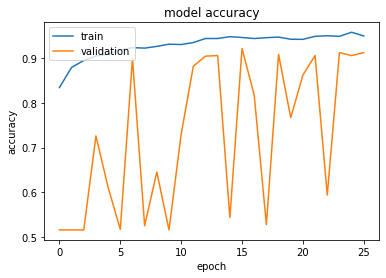

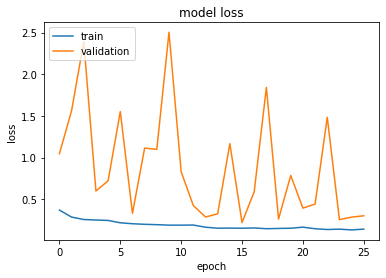

In [17]:
#  "Accuracy"
plt.plot(history.history['accuracy'])  #准确度
plt.plot(history.history['val_accuracy'])  #验证集准确度
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"   损失量
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Model Evaluation

### on test dataset

In [18]:
# load the trained CNN model
cnn_model = load_model(MODEL_LOC)

In [19]:
# storing the true classes of the test dataset  存储为真的类别的测试集
y_true = test_dataset.classes

# predicting the classes of the test dataset  预测测试数据集的类别
y_pred = cnn_model.predict(test_dataset, steps=len(test_dataset), verbose=1)
print(y_pred)
# Storing the predicted probability   存储预测概率
y_pred_prob = y_pred[:, 1]

# Storing the binary classes for the predictions  存储两种分类的预测集
y_pred_binary = y_pred_prob > 0.5   #概率大于0.5

24/24 [==============================] - 18s 725ms/step
[[0.97840184 0.02159817]
 [0.9755956  0.02440444]
 [0.8861094  0.1138906 ]
 ...
 [0.0236681  0.97633195]
 [0.02484128 0.97515875]
 [0.10338201 0.89661795]]


In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
classification_report, roc_auc_score, roc_curve

In [21]:
# confusion matrix for test dataset 测试集的混淆矩阵
print('\nConfusion Matrix for Test Dataset\n -------------------------')
cm = confusion_matrix(y_true, y_pred_binary)
print(cm)


Confusion Matrix for Test Dataset
 -------------------------
[[331  35]
 [ 24 366]]


Text(0.5, 1.0, 'Confusion Matrix for Test Dataset')

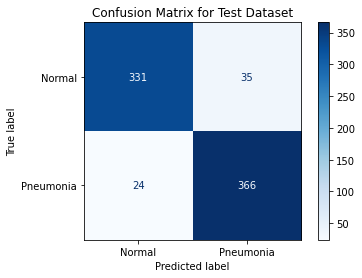

In [22]:
#测试集混淆矩阵画图
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Pneumonia'])
cm_display.plot(cmap = 'Blues')
plt.title('Confusion Matrix for Test Dataset')

In [29]:
# classification report
# accuracy: (tp + tn) / (p + n) #正确率
# precision tp / (tp + fp)  #精确度
# recall: tp / (tp + fn)  #召回
# f1_score: 2 tp / (2 tp + fp + fn)   #f1得分
#print('\nClassification Report\n -------------------------')  #分类报告

#print(classification_report(y_true, y_pred_binary))  

In [24]:
# ROC AUC     ROC曲线   AUC：ROC曲线下方的面积大小
auc = roc_auc_score(y_true, y_pred_prob)
print(f'ROC AUC (Test Dataset) {auc:.2}')


ROC AUC (Test Dataset) 0.97


AUC = 1	完美分类器
AUC = [0.85, 0.95]	效果很好
AUC = [0.7, 0.85]	效果一般
AUC = [0.5, 0.7]	效果较低，但用于预测股票已经很不错了
AUC = 0.5	跟随机猜测一样，模型没有预测价值
AUC < 0.5	比随机猜测还差；但只要总是反预测而行，就优于随机猜测

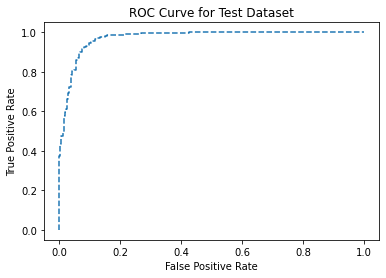

In [25]:
# calculate roc curves  计算roc曲线
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)

# plot the roc curve for the model
plt.figure()
plt.plot(fpr, tpr, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Dataset')
plt.show()

ROC曲线的纵坐标为真阳率true positive rate（TPR）（也就是recall），横坐标为假阳率false positive rate（FPR），这两个指标的分母都是相对真实label说的，TPR即真实正例中对的比例，FPR即真实负例中的错的比例。

因此，阈值的选择取决于在假正例和假反例之间进行平衡的能力。

### on validation dataset

In [26]:
# storing the true classes of the test dataset  存储正确的测试数据
y_true_val = val_dataset.classes

# predicting the classes of the test dataset    判断正确的测试集
y_pred_val = cnn_model.predict(val_dataset, steps=len(val_dataset), verbose=1)

# Storing the predicted probability   存储预测概率
y_pred_val_prob = y_pred_val[:, 1]

# Storing the binary classes for the predictions
y_pred_val_binary = y_pred_val_prob > 0.5   #概率大于0.5

3/3 [==============================] - 3s 1s/step



Confusion Matrix for Validation Dataset
 -------------------------
[[40  7]
 [ 8 40]]


Text(0.5, 1.0, 'Confusion Matrix for Validation Dataset')

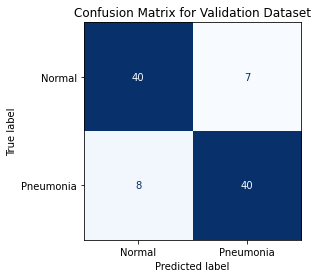

In [27]:
# confusion matrix for validation dataset  混淆矩阵数据集
print('\nConfusion Matrix for Validation Dataset\n -------------------------')
cm_val = confusion_matrix(y_true_val, y_pred_val_binary)   #验证集混淆矩阵 
print(cm_val)

cm_display_val = ConfusionMatrixDisplay(cm_val, display_labels=['Normal', 'Pneumonia'])
cm_display_val.plot(cmap='Blues', colorbar=False)
plt.title('Confusion Matrix for Validation Dataset')